# Convolution (in context of image filter)
* Imagine 6x6 matrix representing a image
* And a 3x3 matrix representing a filter (for example blur)
* You take a 3x3 part of the matrix and perform element multiplication with the filter matrix
* The part is a window that is being moved.
* Then you add those values together and put it in a new matrix
* The neurons are not fully connected but only locally connected
* Pooling (down-sampling;subsampling) - Taking data away (why?)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Convert MNIST Image Files into a Tensor of 4-Dimensions (# of images, Height, Width, Color Channel)
transform = transforms.ToTensor()

In [3]:
# Train Data
train_data = datasets.MNIST(root='./cnn_data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./cnn_data', train=False, download=True, transform=transform)

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

# Define CNN model
* Not actual coded model. Just steps how the model will work.

In [7]:
conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1)
conv2 = nn.Conv2d(6, 16, kernel_size=3, stride=1)

In [8]:
# Grab 1 MNIST record/image
for i, (X_Train, y_train) in enumerate(train_data):
    break

In [9]:
X_Train.shape # 1 image with size 28x28

torch.Size([1, 28, 28])

In [10]:
x = X_Train.view(1,1,28,28) # 4 dimensions (for color channel as well)

In [11]:
# Perform first convolution
x = F.relu(conv1(x))  # Rectified linear unit for activation function conv1

In [12]:
x.shape  # 1 Single image, 6 filters we asked for, 26x26 because we do not have padding on. Since the image has dark 
# background which we do not care about. We care about the middle.

torch.Size([1, 6, 26, 26])

In [13]:
# Pass through the pooling layer
x = F.max_pool2d(x, kernel_size=2, stride=2)

In [14]:
x.shape  # 1 is one image, 6 filters, 13x13 it is taking information away, 26/2 = 13

torch.Size([1, 6, 13, 13])

In [15]:
# Do second conv. layer
x = F.relu(conv2(x))

In [16]:
x.shape  # Same thing as previously, no padding, lost 2 px around the outside of the image.

torch.Size([1, 16, 11, 11])

In [17]:
# Pooling layer
x = F.max_pool2d(x, kernel_size=2, stride=2)

In [18]:
x.shape  # Final size

torch.Size([1, 16, 5, 5])

In [19]:
((28 - 2) / 2 - 2) / 2

5.5

# Actual model

In [20]:
# Model class
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3, stride=1)
        # Fully connected layer
        self.fc1 = nn.Linear(5*5*16, 120) # Final size from the model definition
        self.fc2 = nn.Linear(120, 84)  # Random vals
        self.fc3 = nn.Linear(84, 10)  # 10 is the amount of images we have
    
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, kernel_size=2, stride=2)
        # Second pass
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, kernel_size=2, stride=2)
        
        # Re-View to flatten it out
        X = X.view(-1, 16*5*5)  # Negative one so that we can vary the batch size
        
        # Fully connected layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [21]:
# Create an instance of our model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Smaller the Learning Rate, longer its gonna take to train

In [23]:
import time
start_time = time.time()

# Create variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop of epochs
for epoch in range(epochs):
    # Iteration trackers
    trn_corr = 0
    tst_corr = 0
    
    # Train
    for batch, (X_train, y_train) in enumerate(train_loader):
        batch+=1  # Start batches at 1
        y_pred = model(X_train)  # Get predicted values from training set (not flattened, 2D)
        loss = criterion(y_pred, y_train)  # How off are we? Compare predictions to the correct answers
        
        predicted = torch.max(y_pred.data, 1)[1]  # Add up the number of correct predictions. Indexed off the first point
        batch_correct = (predicted == y_train).sum()  # How many we got correct from this batch, True = 1, False = 0 and we sum those up 
        trn_corr += batch_correct  # Keep track of training success
        
        # Update our parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print results
        if batch % 600 == 0:
            print(f'Epoch: {epoch}, Batch: {batch}, Loss: {loss.item():.4f}')
    
        train_losses.append(loss)
        train_correct.append(trn_corr)
        
    # Test
    with torch.no_grad():  # No gradient so we don't update our weights and biases with our test data
        for batch, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]  # Adding up correct predictions
            
            tst_corr += (predicted == y_test).sum()
        
        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)
            

current_time = time.time()
total_time = current_time - start_time
print(f'Training time: {(total_time/60):.4f} minutes.')

Epoch: 0, Batch: 600, Loss: 0.1624
Epoch: 0, Batch: 1200, Loss: 0.1615
Epoch: 0, Batch: 1800, Loss: 0.5042
Epoch: 0, Batch: 2400, Loss: 0.1444
Epoch: 0, Batch: 3000, Loss: 0.0064
Epoch: 0, Batch: 3600, Loss: 0.3920
Epoch: 0, Batch: 4200, Loss: 0.0033
Epoch: 0, Batch: 4800, Loss: 0.0019
Epoch: 0, Batch: 5400, Loss: 0.0721
Epoch: 0, Batch: 6000, Loss: 0.0004
Epoch: 1, Batch: 600, Loss: 0.0034
Epoch: 1, Batch: 1200, Loss: 0.1656
Epoch: 1, Batch: 1800, Loss: 0.0021
Epoch: 1, Batch: 2400, Loss: 0.0038
Epoch: 1, Batch: 3000, Loss: 0.0324
Epoch: 1, Batch: 3600, Loss: 0.3864
Epoch: 1, Batch: 4200, Loss: 0.0674
Epoch: 1, Batch: 4800, Loss: 0.0003
Epoch: 1, Batch: 5400, Loss: 0.0004
Epoch: 1, Batch: 6000, Loss: 0.2017
Epoch: 2, Batch: 600, Loss: 0.0504
Epoch: 2, Batch: 1200, Loss: 0.0033
Epoch: 2, Batch: 1800, Loss: 0.0031
Epoch: 2, Batch: 2400, Loss: 0.0255
Epoch: 2, Batch: 3000, Loss: 0.0085
Epoch: 2, Batch: 3600, Loss: 0.0015
Epoch: 2, Batch: 4200, Loss: 0.0861
Epoch: 2, Batch: 4800, Loss: 0.

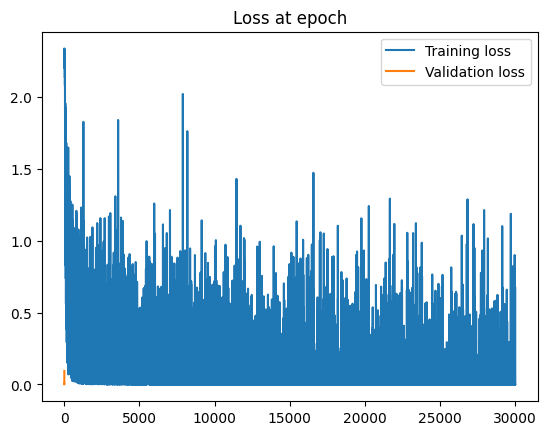

In [24]:
# Graph the loss of each epoch
train_losses_list = [tl.item() for tl in train_losses]
plt.plot(train_losses_list, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss at epoch')
plt.legend()

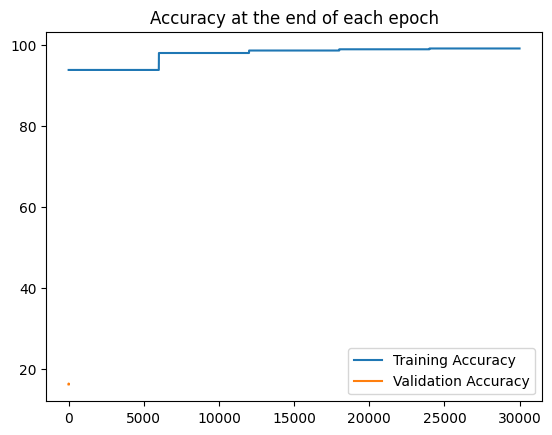

In [25]:
# Graph accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/600 for t in test_correct], label='Validation Accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

In [26]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [27]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_everything:
        y_val = model(X_test)
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == y_test).sum()

In [28]:
# Did correct
correct.item() / len(test_data) * 100

98.54

In [29]:
# Grab an image
test_data[4143] # Tensor with an image in it...at the end it shows label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [30]:
# Grab just the data
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [31]:
# Reshape it
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

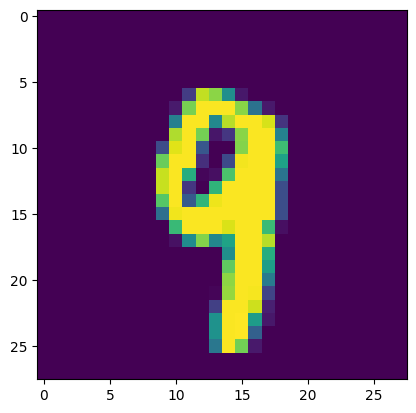

In [32]:
# Show image
plt.imshow(test_data[4143][0].reshape(28,28))

In [33]:
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[4143][0].view(1,1,28,28)) # batch size of 1, 1 color channel, 28x28 image

In [34]:
new_prediction

tensor([[-2.2886e+01, -2.0532e+01, -2.3966e+01, -1.7668e+01, -8.2908e+00,
         -2.0454e+01, -3.4810e+01, -1.4056e+01, -1.4179e+01, -2.5233e-04]])

In [35]:
new_prediction.argmax()

tensor(9)

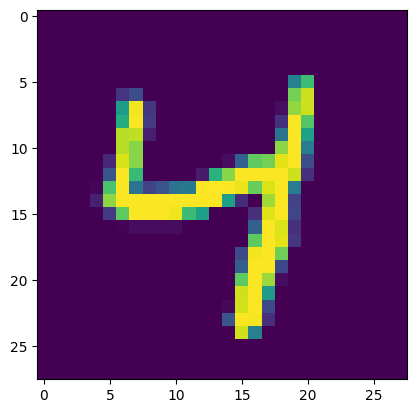

In [36]:
plt.imshow(test_data[1978][0].reshape(28,28))

In [37]:
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[1978][0].view(1,1,28,28))

In [38]:
new_prediction

tensor([[-26.1388, -18.5392, -25.5581, -31.1869,   0.0000, -22.6956, -23.2529,
         -23.3080, -23.4850, -17.9956]])

In [39]:
new_prediction.argmax()

tensor(4)